<div align="center"><h3>HW7</h3></div>
<div align="center"><h5>Mohammadreza Ghofrani, 400131076</h5></div>

# FCGAN

## Setup

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

# Constants


In [2]:
epochs = 30
img_dim = 64
latent_dim = 128
num_examples_to_generate = 100

# To visualize progress
seeds = tf.random.normal(shape=(num_examples_to_generate, latent_dim))

## Prepare Dataset

In [3]:
def preprocess(img):
    return tf.image.resize(img['image'], (img_dim, img_dim))/ 255

setattr(tfds.image_classification.cats_vs_dogs,
        '_URL',
        "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip")

train_ds = tfds.load('cats_vs_dogs', 
                    split = 'train',
                    shuffle_files = True)

X_train = train_ds.map(preprocess).batch(32)

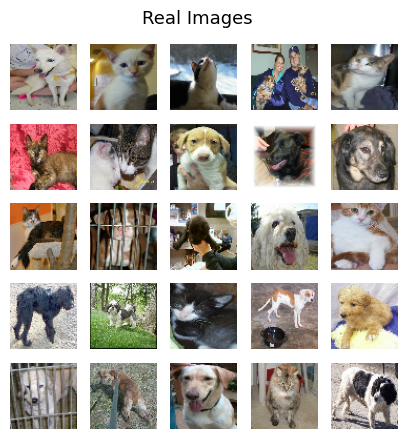

In [4]:
fig = plt.figure(figsize=(5, 5))

for batch in X_train.take(1):
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.imshow((batch[i, :, :] * 255).numpy().astype('uint8'))
        plt.axis('off')

plt.suptitle('Real Images',  y=0.95, fontsize=13)
plt.show()

# Discriminator

In [3]:
def create_discriminator():
    discriminator = keras.Sequential(
        [
            keras.Input(shape=(64, 64, 3)),
            layers.Flatten(),
            layers.Dense(512, activation='relu'),
            layers.Dense(128, activation='relu'),
            layers.Dense(32, activation='relu'),
            layers.Dense(8, activation='relu'),
            layers.Dense(1, activation="sigmoid"),
        ],
        name="discriminator",
    )
    return discriminator

## Generator

In [6]:
def create_generator(n_layer):
    generator = keras.Sequential(name="generator")
    generator.add(keras.Input(shape=(latent_dim,)))

    for li in n_layer:
        generator.add(layers.Dense(256 * li, use_bias=True))
        generator.add(layers.BatchNormalization())
        generator.add(layers.LeakyReLU(0.2))

    generator.add(layers.Dense(img_dim * img_dim * 3, activation='tanh'))
    generator.add(layers.Reshape((img_dim, img_dim, 3)))

    return generator

## GAN model

In [7]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, noisy=False, mean=0.0, stddev=1.0):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.noisy = noisy
        self.mean = mean
        self.stddev = stddev

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, latent_dim))

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Add random noise to the images - important trick!
        if self.noisy:
            real_images += tf.random.normal(0, self.stddev, size=(batch_size, img_dim, img_dim, 3))

        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

## Create a callback that periodically saves generated images

In [17]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, prefix):
        self.prefix = prefix

    def on_epoch_end(self, epoch, logs=None):
        generated_images = self.model.generator(seeds)
        generated_images *= 255
        generated_images.numpy()

        plt.figure(figsize=(5, 5))
        for i in range(num_examples_to_generate):
            plt.subplot(10, 10, i+1)
            img = keras.preprocessing.image.array_to_img(generated_images[i])
            plt.imshow(img)
            plt.axis('off')
        plt.savefig("%s/generated_img_%02d.png" % (self.prefix, epoch + 1))
        plt.close()

# Train

## Checking number of layer in generator

In [18]:
!mkdir -p nlayer1 nlayer3 nlayer5
for n_layer in (1, 3, 5):
    generator = create_generator(n_layer)
    discriminator = create_discriminator()
    gan = GAN(discriminator=discriminator, generator=generator)
    gan.compile(
        d_optimizer=keras.optimizers.Adam(learning_rate=0.0002),
        g_optimizer=keras.optimizers.Adam(learning_rate=0.0002),
        loss_fn=keras.losses.BinaryCrossentropy(),
    )
    gan.fit(X_train, epochs=epochs, callbacks=[GANMonitor(prefix="nlayer%d" % n_layer)], verbose=0)
    print('Train is finished for nlayer=%d' % n_layer)

Train is finished for nlayer=1


## Checking results with adding noise

In [ ]:
!mkdir -p noisy_std0.5 noisy_std2.0 noisy_std5.0
for stddev in (0.5, 2, 5):
    generator = create_generator(n_layer)
    discriminator = create_discriminator()
    gan = GAN(discriminator=discriminator, generator=generator, noisy=True, mean=0, stddev=stddev)
    gan.compile(
        d_optimizer=keras.optimizers.Adam(learning_rate=0.0002),
        g_optimizer=keras.optimizers.Adam(learning_rate=0.0002),
        loss_fn=keras.losses.BinaryCrossentropy(),
    )
    gan.fit(X_train, epochs=epochs, callbacks=[GANMonitor(prefix="noisy_std%d" % stddev)], verbose=0)
    print('Train is finished for nlayer=%d' % n_layer)